--- Using Mock Data ---

--- Data Preprocessing Complete ---
                     Temperature (C)  Humidity (%)  Wind Speed (m/s)  \
DateTime                                                               
2022-08-30 20:30:00             17.0            82              4.63   
2022-08-30 23:30:00             16.5            85              4.12   
2022-08-31 02:30:00             16.0            88              3.61   
2022-08-31 05:30:00             15.5            90              3.10   
2022-08-31 08:30:00             15.0            92              2.59   

                     Precipitation (mm)  
DateTime                                 
2022-08-30 20:30:00                 0.5  
2022-08-30 23:30:00                 0.0  
2022-08-31 02:30:00                 1.2  
2022-08-31 05:30:00                 0.0  
2022-08-31 08:30:00                 0.2  

--- Task 5: Basic Data Analysis ---
       Temperature (C)  Humidity (%)  Wind Speed (m/s)  Precipitation (mm)
count        10.000000     1

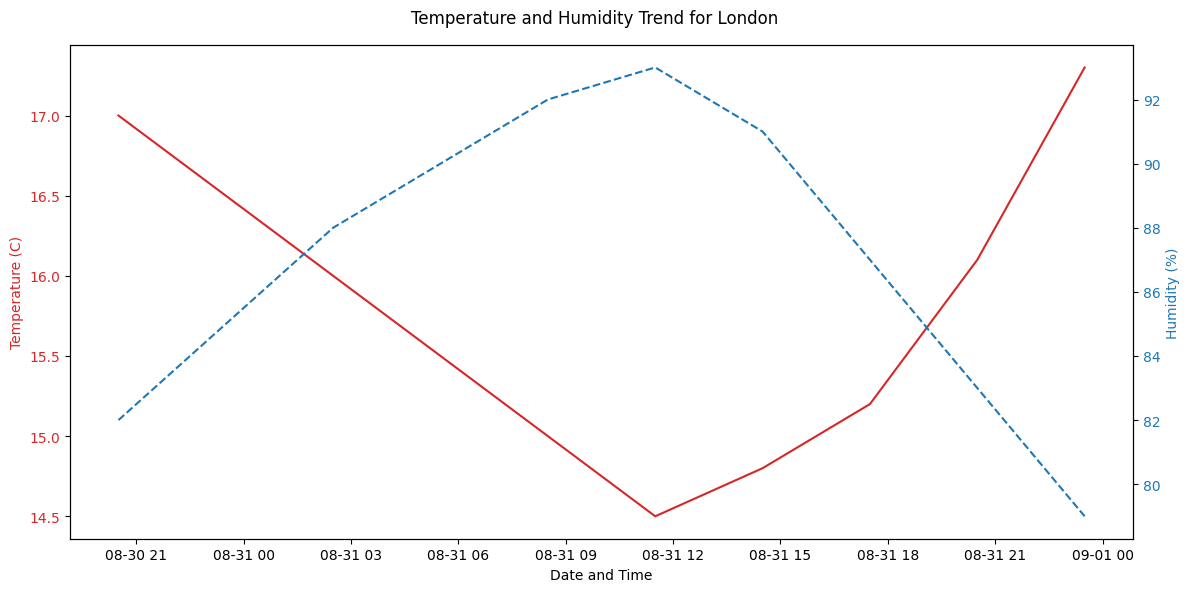

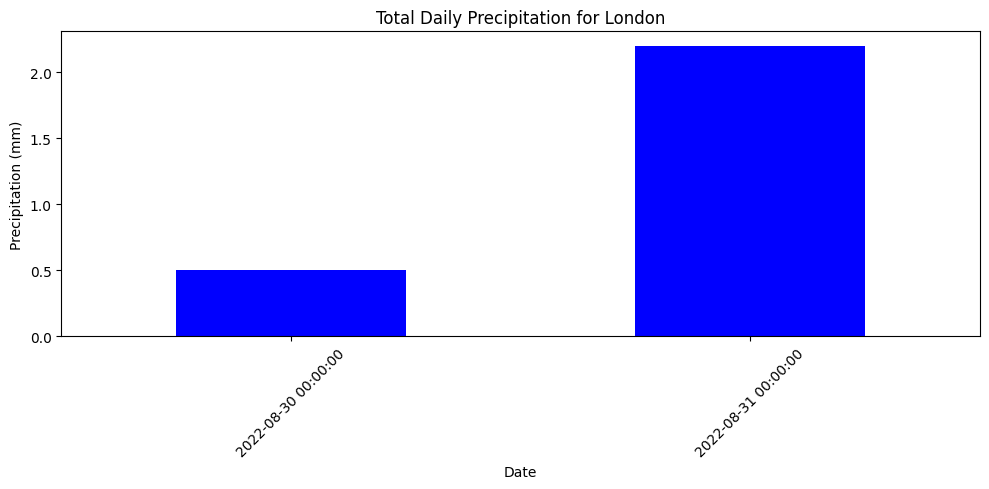

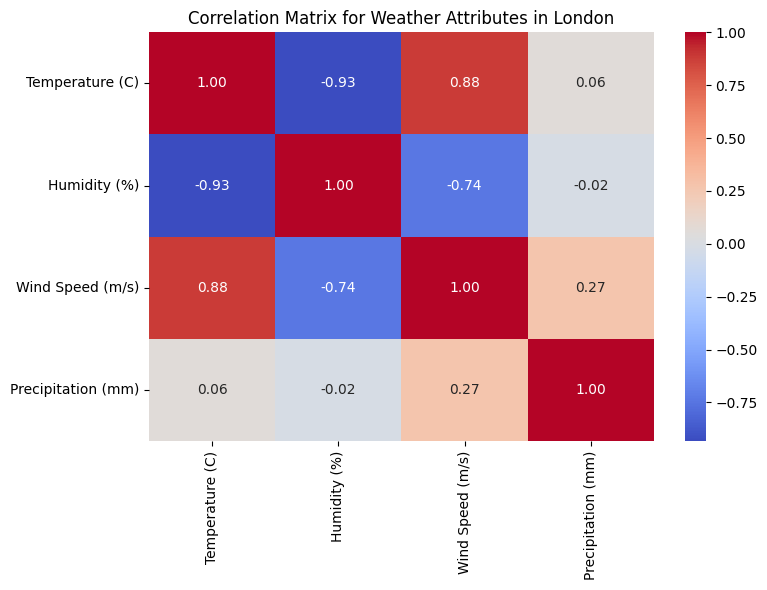

In [4]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from datetime import datetime

# --- Task 1: Enter Your API Key ---
# (Get your key from https://openweathermap.org/api)
API_KEY = ""

# --- Configuration ---
CITY_NAME = "London"
UNITS = "metric"  # Use 'metric' for Celsius, 'imperial' for Fahrenheit

# Set to True to run the script with sample data (no API key needed)
# Set to False to use the live OpenWeatherMap API
USE_MOCK_DATA = True

# Mock data (simulating the API response for "London")
# This is used if USE_MOCK_DATA is True
MOCK_DATA = {
    "cod": "200",
    "message": 0,
    "cnt": 40,
    "list": [
        {"dt": 1661871600, "main": {"temp": 17.0, "humidity": 82}, "wind": {"speed": 4.63}, "rain": {"3h": 0.5}},
        {"dt": 1661882400, "main": {"temp": 16.5, "humidity": 85}, "wind": {"speed": 4.12}},
        {"dt": 1661893200, "main": {"temp": 16.0, "humidity": 88}, "wind": {"speed": 3.61}, "rain": {"3h": 1.2}},
        {"dt": 1661904000, "main": {"temp": 15.5, "humidity": 90}, "wind": {"speed": 3.10}},
        {"dt": 1661914800, "main": {"temp": 15.0, "humidity": 92}, "wind": {"speed": 2.59}, "rain": {"3h": 0.2}},
        {"dt": 1661925600, "main": {"temp": 14.5, "humidity": 93}, "wind": {"speed": 2.08}},
        {"dt": 1661936400, "main": {"temp": 14.8, "humidity": 91}, "wind": {"speed": 2.21}},
        {"dt": 1661947200, "main": {"temp": 15.2, "humidity": 87}, "wind": {"speed": 2.85}, "rain": {"3h": 0.8}},
        {"dt": 1661958000, "main": {"temp": 16.1, "humidity": 83}, "wind": {"speed": 3.12}},
        {"dt": 1661968800, "main": {"temp": 17.3, "humidity": 79}, "wind": {"speed": 3.55}},
    ],
    "city": {"id": 2643743, "name": "London", "coord": {"lat": 51.5074, "lon": -0.1278}, "country": "GB"}
}


def get_weather_data(api_key, city, units):
    """
    Task 2: Interact with the API to retrieve weather data.
    """
    if USE_MOCK_DATA:
        print("--- Using Mock Data ---")
        return MOCK_DATA

    print("--- Fetching Live Data from OpenWeatherMap ---")
    # Using the 5 day / 3 hour forecast API
    base_url = "https://api.openweathermap.org/data/2.5/forecast"
    params = {
        "q": city,
        "appid": api_key,
        "units": units
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raises an HTTPError for bad responses (4xx or 5xx)
        return response.json()
    except requests.exceptions.HTTPError as err:
        if response.status_code == 401:
            print(f"Error: Invalid API Key. Please check your key.")
        else:
            print(f"HTTP Error: {err}")
    except requests.exceptions.RequestException as err:
        print(f"Request Error: {err}")

    return None

def process_data(data):
    """
    Tasks 3 & 4: Extract attributes, clean, and preprocess the data.
    """
    if not data or 'list' not in data:
        print("No forecast data found.")
        return None, None

    # Extract data for the DataFrame
    forecasts = []
    for item in data['list']:
        forecast = {
            "DateTime": datetime.fromtimestamp(item['dt']),
            "Temperature (C)": item['main']['temp'],
            "Humidity (%)": item['main']['humidity'],
            "Wind Speed (m/s)": item['wind']['speed'],
            # Handle missing 'rain' data
            "Precipitation (mm)": item.get('rain', {}).get('3h', 0)
        }
        forecasts.append(forecast)

    # Create a Pandas DataFrame
    df = pd.DataFrame(forecasts)

    # Set DateTime as the index (best for time-series analysis)
    df.set_index("DateTime", inplace=True)

    # Extract geographical info for Task 8
    geo_info = {
        "lat": data['city']['coord']['lat'],
        "lon": data['city']['coord']['lon'],
        "city_name": data['city']['name']
    }

    print("\n--- Data Preprocessing Complete ---")
    print(df.head())
    return df, geo_info

def analyze_and_aggregate(df):
    """
    Tasks 5 & 7: Perform data modeling and aggregation.
    """
    print("\n--- Task 5: Basic Data Analysis ---")
    print(df.describe())

    print("\n--- Task 7: Daily Aggregation ---")
    # Resample the 3-hour data into daily statistics
    daily_stats = df.resample('D').agg({
        "Temperature (C)": ['mean', 'max', 'min'],
        "Humidity (%)": ['mean'],
        "Precipitation (mm)": ['sum']
    })

    print("Daily Aggregated Weather Stats:")
    print(daily_stats)
    return daily_stats

def visualize_data(df, daily_stats):
    """
    Task 6: Visualize the weather data.
    """
    print("\n--- Task 6: Visualizing Data ---")

    # Plot 1: Temperature and Humidity over time (Line Chart)
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:red'
    ax1.set_xlabel('Date and Time')
    ax1.set_ylabel('Temperature (C)', color=color)
    ax1.plot(df.index, df['Temperature (C)'], color=color, label='Temperature')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # Instantiate a second y-axis
    color = 'tab:blue'
    ax2.set_ylabel('Humidity (%)', color=color)
    ax2.plot(df.index, df['Humidity (%)'], color=color, linestyle='--', label='Humidity')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.suptitle(f'Temperature and Humidity Trend for {CITY_NAME}')
    fig.tight_layout()
    plt.savefig('temperature_humidity.png')
    print("Saved 'temperature_humidity.png'")

    # Plot 2: Daily Precipitation (Bar Plot)
    plt.figure(figsize=(10, 5))
    daily_stats['Precipitation (mm)']['sum'].plot(kind='bar', color='blue')
    plt.title(f'Total Daily Precipitation for {CITY_NAME}')
    plt.ylabel('Precipitation (mm)')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('daily_precipitation.png')
    print("Saved 'daily_precipitation.png'")

def visualize_relationships(df):
    """
    Task 9: Explore and visualize relationships (Correlation Plot).
    """
    print("\n--- Task 9: Visualizing Relationships ---")

    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix for Weather Attributes in {CITY_NAME}')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    print("Saved 'correlation_heatmap.png'")

def visualize_map(geo_info):
    """
    Task 8: Incorporate geographical information (Map).
    """
    if not geo_info:
        print("No geographical info to plot.")
        return

    print(f"\n--- Task 8: Creating Geographical Map ---")

    lat = geo_info['lat']
    lon = geo_info['lon']
    city = geo_info['city_name']

    # Create a map centered on the city
    m = folium.Map(location=[lat, lon], zoom_start=10)

    # Add a marker for the city
    folium.Marker(
        [lat, lon],
        popup=f"<b>{city}</b>",
        tooltip=city
    ).add_to(m)

    # Save the map to an HTML file
    m.save("weather_map.html")
    print("Saved 'weather_map.html'. Open this file in your browser.")


# --- Main execution ---
if __name__ == "__main__":
    # Check if API key is set when not using mock data
    if not USE_MOCK_DATA and API_KEY == "YOUR_API_KEY_HERE":
        print("Error: Please set your API_KEY in the script.")
    else:
        # Tasks 2
        weather_json = get_weather_data(API_KEY, CITY_NAME, UNITS)

        if weather_json:
            # Tasks 3 & 4
            weather_df, geo_info = process_data(weather_json)

            if weather_df is not None:
                # Tasks 5 & 7
                daily_df = analyze_and_aggregate(weather_df)

                # Task 6
                visualize_data(weather_df, daily_df)

                # Task 9
                visualize_relationships(weather_df)

                # Task 8
                visualize_map(geo_info)

                print("\n--- Analysis Complete ---")
                print("Generated 3 plot images and 1 map file.")

In [3]:
pip install folium


  Using cached folium-0.20.0-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached branca-0.8.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached xyzservices-2025.10.0-py3-none-any.whl.metadata (4.3 kB)
Using cached folium-0.20.0-py2.py3-none-any.whl (113 kB)
Using cached branca-0.8.2-py3-none-any.whl (26 kB)
Using cached xyzservices-2025.10.0-py3-none-any.whl (92 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
